# FILTERING MOBILE PHONE SPAM WITH THE NAIVE BAYES ALGORITHM

Rosa Karina Torres Calderon

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from scipy import sparse
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

Functions

In [3]:
def generatingWordCloud(dataFrame):
    comment_words = ' '
    stopwords = set(STOPWORDS)
    # iterate through the csv file
    for val in dataFrame.text:
        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        for words in tokens:
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width=800, height=800,background_color='white',stopwords=stopwords, min_font_size=10).generate(comment_words)

    # plot the WordCloud image
    %matplotlib inline
    plt.figure(figsize=(6, 6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# Step 1- Reading the data set

In [4]:
sms = pd.read_csv("sms_spam.csv")
print(sms.head())
print(" ")
print('Tamaño del data set: ' + str(sms.shape))

   type                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
 
Tamaño del data set: (5574, 2)


# Step 2- Exploring and preparing the data

Número de mensajes spam y ham: 
ham     4827
spam     747
Name: type, dtype: int64

Wordcloud de mensajes importantes


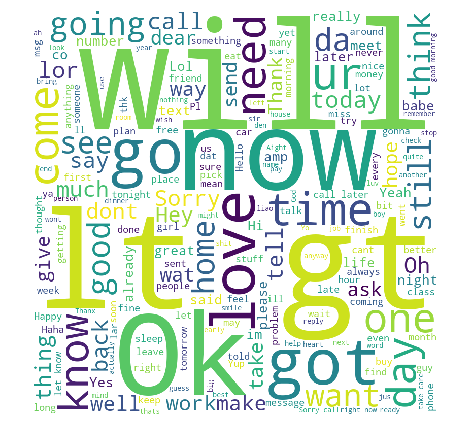


Wordcloud de spam


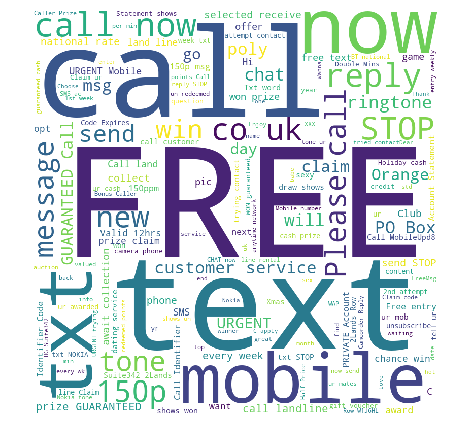

In [5]:
# Output how many messages are spam or ham
print("Número de mensajes spam y ham: ")
print(sms["type"].value_counts()) 

#Visualizing text data with wordclouds. 
#It shows frequency at which words appear in text data
print("\nWordcloud de mensajes importantes")
generatingWordCloud(sms.loc[sms['type'] == 'ham'])

print("\nWordcloud de spam")
generatingWordCloud(sms.loc[sms['type'] == 'spam'])


Data preparation - processing text data for analysis

In [6]:
sms['text'] = sms.text.map(lambda x: x.lower())  #Convert all SMS messages to lowercase
sms['text'] = sms.text.str.replace('[^\w\s]','') #Remove punctuation
pattern = '[0-9]'
sms['text'] = [re.sub(pattern, '', i) for i in sms['text']] #Remove any numbers 
sms['text'] = sms['text'].apply(nltk.word_tokenize)  #Words tokenize
nltk_words = list(stopwords.words('english')) #List of stopwords in english
for i in range(0,len(sms)):
    sms['text'][i] = [w for w in sms['text'][i] if w not in nltk_words]  
sms['text'] = sms['text'].apply(lambda x: ' '.join(x)) # This converts the list of words into space-separated strings

print('Lista de palabras auxiliares en inglés: ')
print(nltk_words )
print('')
print('Data set procesado')
print(sms.head(10))

Lista de palabras auxiliares en inglés: 
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not

Creating the vector space model 

In [7]:
#Create the vector space model (Bag of words)
count_vect = CountVectorizer()
bagofWords = count_vect.fit_transform(sms['text'])
print('Tamaño del modelo de espacio vectorial con todas las palabras: ')
print(bagofWords.shape)

#Create the vector space model (Bag of words) with space reduction, with words that appear in more than five messages.
count_vect = CountVectorizer(min_df = 5)
bagofWords = count_vect.fit_transform(sms['text'])
print('\nTamaño del modelo de espacio vectorial con las palabras que aparecen en más de 5 mensajes: ')
print(bagofWords.shape)

Tamaño del modelo de espacio vectorial con todas las palabras: 
(5574, 8482)

Tamaño del modelo de espacio vectorial con las palabras que aparecen en más de 5 mensajes: 
(5574, 1584)


In [8]:
bagofWords = bagofWords.toarray()
print(bagofWords)
bagofWords = csr_matrix(bagofWords)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Data preparation - creating training and test datasets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(bagofWords, sms['type'], test_size=0.2, random_state=69)

# Step 3- Training a Model on the data 

In [13]:
# The multinomial Naive Bayes classifier is suitable for classification with discrete features (words)
model = MultinomialNB(alpha=0.0).fit(X_train, y_train)

/Users/karinatorres/anaconda3/envs/MachineLearning/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


# Step 4- Evaluating model performance

In [14]:
# Evaluating the model in the train set 
train_accuracy = model.score(X_train, y_train)
print('Precisión del modelo(entrenamiento): ' + str(train_accuracy))

Precisión del modelo(entrenamiento): 0.9845256784032295

Matriz de confusión
Predicted   ham  spam   All
True                       
ham        3833    31  3864
spam         38   557   595
All        3871   588  4459

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      3864
        spam       0.95      0.94      0.94       595

   micro avg       0.98      0.98      0.98      4459
   macro avg       0.97      0.96      0.97      4459
weighted avg       0.98      0.98      0.98      4459



In [15]:
# Evaluating the model in the test set 
test_accuracy = model.score(X_test, y_test)
y_pred = model.predict(X_test)

print('Precisión del modelo(prueba): ' + str(test_accuracy))
print('')
print('Matriz de confusión')
print(pd.crosstab(y_test, y_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))
print('')
print(classification_report(y_test,y_pred))

Precisión del modelo(prueba): 0.9704035874439462

Matriz de confusión
Predicted  ham  spam   All
True                      
ham        955     8   963
spam        25   127   152
All        980   135  1115

              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       963
        spam       0.94      0.84      0.89       152

   micro avg       0.97      0.97      0.97      1115
   macro avg       0.96      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115



# Step 5- Improving model performance

In [16]:
# Changing the Laplace estimator (alpha)  
model = MultinomialNB(alpha=1.0).fit(X_train, y_train)

In [17]:
# Evaluating the model in the test set 
test_accuracy = model.score(X_test, y_test)
y_pred = model.predict(X_test)

print('Precisión del modelo(prueba): ' + str(test_accuracy))
print('')
print('Matriz de confusión')
print(pd.crosstab(y_test, y_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))
print('')
print(classification_report(y_test,y_pred))

Precisión del modelo(prueba): 0.9748878923766816

Matriz de confusión
Predicted  ham  spam   All
True                      
ham        953    10   963
spam        18   134   152
All        971   144  1115

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       963
        spam       0.93      0.88      0.91       152

   micro avg       0.97      0.97      0.97      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.97      0.97      0.97      1115

